In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For splitting the data
from sklearn.model_selection import StratifiedShuffleSplit

# Data Scaling
from sklearn.preprocessing import StandardScaler

# Model Evaluation
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 1. ⚙️ Data Preprocessing
---
- The Dataset in quite imbalance for `Tsunami` category and `Depth_(km)`, so we have to consider this while spliting the data for **Train**, **Test**, and **Valid** 
- As from EDA, `Depth_(km)` and `Year` after 2012 was responsible for Tsunami after earthquake
- The `Depth_(km)` was use to create `Depth_Category` to include all the depth in both **Training** and **Testing**

In [2]:
# Importing the dataset
df = pd.read_csv('../data/processed/earthquake_data_tsunami.csv')

In [3]:
# Creating depth categories for stratified sampling
df['Depth_Category'] = pd.cut(df['Depth_(km)'], bins=[1, 100, 200, 400, 600, np.inf], labels=[1, 2, 3, 4, 5])

In [4]:
# Stratified splitting of the dataset into training, validation, and test sets
split_data = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split_data.split(df, df[['Depth_Category', 'Tsunami']]):
    strat_train_set = df.iloc[train_index]
    test_set = df.iloc[test_index].drop('Depth_Category', axis=1) # dropping the helper column
    
split_valid = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, valid_index in split_valid.split(strat_train_set, strat_train_set[['Depth_Category', 'Tsunami']]):
    train_set = strat_train_set.iloc[train_index].drop('Depth_Category', axis=1) # dropping the helper column
    valid_set = strat_train_set.iloc[valid_index].drop('Depth_Category', axis=1) # dropping the helper column

In [5]:
# Saving the datasets 
train_set.to_csv('../data/processed/train_set.csv', index=False)
valid_set.to_csv('../data/processed/valid_set.csv', index=False)
test_set.to_csv('../data/processed/test_set.csv', index=False)

In [6]:
test_set.head()

,Magnitude,Community_Determined_Intensity,Modified_Mercalli_Intensity,Significance,Number_of_Stations,Distance_to_Nearest_Station,Azimuthal_Gap,Depth_(km),latitude,longitude,Year,Month,Tsunami
14,6.6,6,6,1043,141,8.454,34.0,12.00,29.7263,102.279,2022,9,0
250,7.8,7,7,1163,0,1.440,15.0,20.59,0.3819,-79.922,2016,4,1
171,6.5,6,6,743,0,2.719,23.0,529.00,-7.3718,119.802,2018,8,0
416,6.8,6,6,771,596,0.000,19.3,45.00,-28.0940,-70.653,2013,1,0
266,7.2,7,7,827,0,1.116,18.0,22.00,38.2107,72.780,2015,12,0


In [7]:
# Preparing features and labels
# ------------------------------
# For training set
train_features = train_set.drop('Tsunami', axis=1)
train_labels = train_set['Tsunami'].copy()

# For validation set
valid_features = valid_set.drop('Tsunami', axis=1)
valid_labels = valid_set['Tsunami'].copy()

# For test set
test_features = test_set.drop('Tsunami', axis=1)
test_labels = test_set['Tsunami'].copy()


In [8]:
# Scaling the features
# --------------------
# Fit the scaler ONLY on the training data, then transform all sets.
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_features)
valid_scaled = scaler.transform(valid_features)
test_scaled = scaler.transform(test_features)

In [9]:
train_scaled

array([[ 1.29832733,  1.09705037,  1.09705037, ...,  0.8754162 ,
         0.25276326, -0.73988056],
       [-1.00064047, -0.69812296, -0.69812296, ...,  0.56595853,
        -0.89412376,  1.24688068],
       [ 0.37874021,  1.09705037,  1.09705037, ..., -1.03137795,
         0.90812726,  0.39541158],
       ...,
       [-1.00064047, -0.69812296, -0.69812296, ...,  0.77799622,
         0.74428626,  1.24688068],
       [-1.00064047, -0.69812296, -0.69812296, ...,  0.8566988 ,
         0.25276326,  0.11158854],
       [ 0.37874021,  1.09705037,  1.09705037, ...,  0.76198047,
        -0.23875975, -0.73988056]], shape=(468, 12))

# 2. 🤖 Model Comparison and Selection
---

### 2.1 Logistic Regression
- The Logistic Regression confusion matrix shows 82 TN, 48 TP, 13 FP, and 14 FN
- The model achieves ~79% precision and recall for the positive class, indicating it correctly identifies most positive and negative cases but slightly misclassifies some
- Tree-based models like Random Forest or XGBoost may capture additional non-linear patterns, improving performance

---

### 2.2 Random Forest Classifier
- The Random Forest confusion matrix shows 87 TN, 61 TP, 8 FP, and 1 FN
- The model achieves ~94% accuracy and high precision and recall for both classes, indicating it captures most positive and negative cases correctly
- The improved performance compared to Logistic Regression suggests the dataset contains non-linear relationships and feature interactions

---

### 2.3 XGBoost Classifier
- The XGBoost confusion matrix shows 91 TN, 59 TP, 4 FP, and 3 FN
- The model achieves ~96% accuracy with very high precision and recall for both classes, correctly identifying almost all positive and negative cases
- XGBoost outperforms other models, confirming the presence of complex non-linear patterns and making it the final model for testing

In [10]:
# Multiple classification models testing for Tsunami prediction
# ------------------------------------------------------------
# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(train_scaled, train_labels)


# Make predictions on the scaled validation data
lr_validation_prediction = log_reg.predict(valid_scaled)


# Evaluate the model
print("Classification Report for Logistic Regression on Validation Set:")
print(classification_report(valid_labels, lr_validation_prediction))
print("=" * 60)

print("\nConfusion Matrix for Logistic Regression:")
print(confusion_matrix(valid_labels, lr_validation_prediction))
print("=" * 60)

accuracy = accuracy_score(valid_labels, lr_validation_prediction)
print(f"\nValidation Accuracy for Logistic Regression: {accuracy:.4f}")
print("=" * 60)

lr_mse = mean_squared_error(valid_labels, lr_validation_prediction)
print(f"Logistic Regression MSE: {lr_mse:.4f}")
print("=" * 60)


Classification Report for Logistic Regression on Validation Set:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86        95
           1       0.79      0.77      0.78        62

    accuracy                           0.83       157
   macro avg       0.82      0.82      0.82       157
weighted avg       0.83      0.83      0.83       157


Confusion Matrix for Logistic Regression:
[[82 13]
 [14 48]]

Validation Accuracy for Logistic Regression: 0.8280
Logistic Regression MSE: 0.1720


In [11]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(train_features, train_labels)

# Make predictions on the scaled validation data
rf_clf_prediction = rf_clf.predict(valid_features)

# Evaluate the model
print("Classification Report for Random Forest Classifier on Validation Set:")
print(classification_report(valid_labels, rf_clf_prediction))
print("=" * 60)

print("\nConfusion Matrix for Random Forest Classifier:")
print(confusion_matrix(valid_labels, rf_clf_prediction))
print("=" * 60)

accuracy = accuracy_score(valid_labels, rf_clf_prediction)
print(f"\nValidation Accuracy for Random Forest Classifier: {accuracy:.4f}")
print("=" * 60)

rf_mse = mean_squared_error(valid_labels, rf_clf_prediction)
print(f"Random Forest MSE: {rf_mse:.4f}")
print("=" * 60)


Classification Report for Random Forest Classifier on Validation Set:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95        95
           1       0.88      0.98      0.93        62

    accuracy                           0.94       157
   macro avg       0.94      0.95      0.94       157
weighted avg       0.95      0.94      0.94       157


Confusion Matrix for Random Forest Classifier:
[[87  8]
 [ 1 61]]

Validation Accuracy for Random Forest Classifier: 0.9427
Random Forest MSE: 0.0573


In [12]:
# XGBoost Classifier
xgb_clf = XGBClassifier(eval_metric='logloss')
xgb_clf.fit(train_features, train_labels)

# Make predictions on the scaled validation data
xgb_clf_prediction = xgb_clf.predict(valid_features)

# Evaluate the model
print("Classification Report for XGBoost Classifier on Validation Set:")
print(classification_report(valid_labels, xgb_clf_prediction))
print("=" * 60)

print("\nConfusion Matrix for XGBoost Classifier:")
print(confusion_matrix(valid_labels, xgb_clf_prediction))
print("=" * 60)

accuracy = accuracy_score(valid_labels, xgb_clf_prediction)
print(f"\nValidation Accuracy for XGBoost Classifier: {accuracy:.4f}")
print("=" * 60)

xgb_mse = mean_squared_error(valid_labels, xgb_clf_prediction)
print(f"XGBoost MSE: {xgb_mse:.4f}")
print("=" * 60)


Classification Report for XGBoost Classifier on Validation Set:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        95
           1       0.94      0.95      0.94        62

    accuracy                           0.96       157
   macro avg       0.95      0.95      0.95       157
weighted avg       0.96      0.96      0.96       157


Confusion Matrix for XGBoost Classifier:
[[91  4]
 [ 3 59]]

Validation Accuracy for XGBoost Classifier: 0.9554
XGBoost MSE: 0.0446


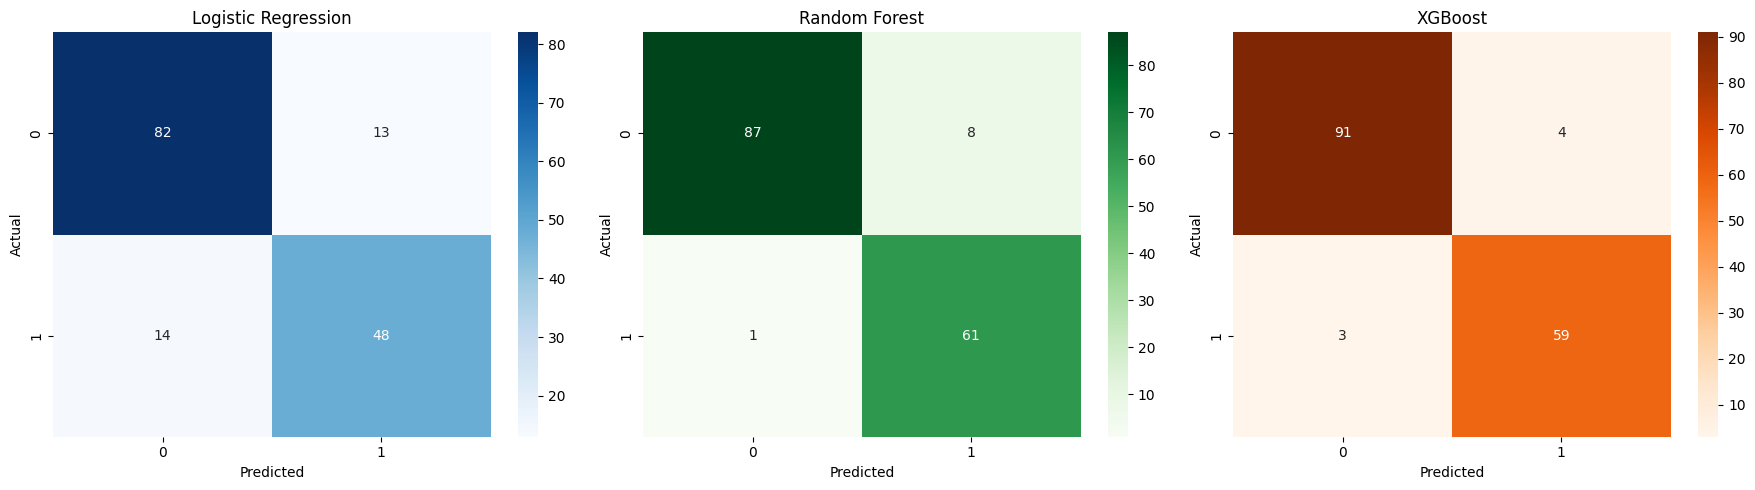

In [13]:
# Confusion Matrix Heatmaps for all models
# ----------------------------------------
# Set up figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Logistic Regression
cm_lr = confusion_matrix(valid_labels, lr_validation_prediction)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Random Forest
cm_rf = confusion_matrix(valid_labels, rf_clf_prediction)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# XGBoost
cm_xgb = confusion_matrix(valid_labels, xgb_clf_prediction)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
axes[2].set_title('XGBoost')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# 3. HyperParamaters
---
- The tuned XGBoost model with a lower learning rate (`0.01`) and moderate tree depth (`max_depth=3`) achieved the best F1 score, indicating a strong balance between precision and recall.

- The `subsample=0.8` parameter prevents overfitting by training each tree on a random subset of data.

- The increased `n_estimators=200` allows the model to learn patterns gradually, improving generalization.

- Overall, the tuned **XGBoost** model shows improved and stable performance compared to the baseline, making it the final selected model for test evaluation.

In [18]:
# Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.2, 0.1, 0.01],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=XGBClassifier(eval_metric='logloss'), 
                           param_grid=param_grid, 
                           scoring='f1', 
                           cv=3)
grid_search.fit(train_features, train_labels)
best_model = grid_search.best_estimator_


In [19]:
# Print best parameters
print("Best Parameters from Grid Search:")
print(grid_search.best_params_)
print("=" * 80)

# Print the best model
print("\nBest Model:")
print(best_model)
print("=" * 80)

# Print the best F1 score achieved
print("\nBest F1 Score from CV:")
print(round(grid_search.best_score_, 2))
print("=" * 80)

Best Parameters from Grid Search:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Best Model:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

Best F1 Score from CV:
0.91


### ✅ Conclusion on Final Model Selection
---
- Among the three classifiers, **XGBoost** achieves the highest validation accuracy (~96%) and strong precision and recall for both classes.  
- Logistic Regression provided a baseline and highlighted some non-linear patterns in the dataset.  
- Random Forest performed very well, handling non-linearities and feature interactions effectively.  
- XGBoost slightly outperforms the other models, confirming it captures complex patterns in the data.  
- Therefore, **XGBoost is selected as the final model** for evaluating on the unseen test set with `{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}` hyperparameters.